In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


### Config model

In [ ]:
max_seq_length = 10000
dtype = None
load_in_4bit = True
model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.8.1: Fast Llama patching. Transformers: 4.54.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.8.1 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


### Data prep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Bảo
def generate_text(row):
    prompt = f"""Analyze the following memory dump data to detect potential malware activity. Classify it into one of the following categories: [Benign, Malware]. Focus on identifying anomalies and behaviors consistent with malicious activity, but take into account that certain benign processes can exhibit behaviors such as memory injections, high handle counts, or missing modules.
## System Information:
- Total Processes: {row['pslist_nproc']}
- Processes without Parent PID: {row['pslist_nppid']}
- Average Threads Per Process: {row['pslist_avg_threads']}
- Number of 64-Bit Processes: {row['pslist_nprocs64bit']}
## DLL Information:
- Total DLL Count: {row['dlllist_ndlls']}
- Average DLLs Per Process: {row['dlllist_avg_dlls_per_proc']}
## Handle and Object Information:
- Total Handles: {row['handles_nhandles']}
- Average Handles Per Process: {row['handles_avg_handles_per_proc']}
- Ports: {row['handles_nport']}, Files: {row['handles_nfile']}, Events: {row['handles_nevent']}
- Desktops: {row['handles_ndesktop']}, Keys: {row['handles_nkey']}, Threads: {row['handles_nthread']}
- Directories: {row['handles_ndirectory']}, Semaphores: {row['handles_nsemaphore']}, Timers: {row['handles_ntimer']}
- Sections: {row['handles_nsection']}, Mutants: {row['handles_nmutant']}
## Module Information:
- Modules Missing from Load List: {row['ldrmodules_not_in_load']}
- Modules Missing from Init List: {row['ldrmodules_not_in_init']}
- Modules Missing from Memory: {row['ldrmodules_not_in_mem']}
- Average Modules Missing from Load List: {row['ldrmodules_not_in_load_avg']}
- Average Modules Missing from Init List: {row['ldrmodules_not_in_init_avg']}
- Average Modules Missing from Memory: {row['ldrmodules_not_in_mem_avg']}
## Memory Indicators:
- Memory Injections Detected: {row['malfind_ninjections']}
- Memory Commit Charge: {row['malfind_commitCharge']}
- Memory Protection Anomalies: {row['malfind_protection']}
- Unique Memory Injections: {row['malfind_uniqueInjections']}
## Process Cross-View Discrepancies:
- Not in Pslist: {row['psxview_not_in_pslist']}
- Not in EProcess Pool: {row['psxview_not_in_eprocess_pool']}
- Not in EThread Pool: {row['psxview_not_in_ethread_pool']}
- Not in PspCid List: {row['psxview_not_in_pspcid_list']}
- Not in CSRSS Handles: {row['psxview_not_in_csrss_handles']}
- Not in Session: {row['psxview_not_in_session']}
- Not in Deskthrd: {row['psxview_not_in_deskthrd']}
- Average False Matches in Pslist: {row['psxview_not_in_pslist_false_avg']}
- Average False Matches in EProcess Pool: {row['psxview_not_in_eprocess_pool_false_avg']}
- Average False Matches in EThread Pool: {row['psxview_not_in_ethread_pool_false_avg']}
- Average False Matches in PspCid List: {row['psxview_not_in_pspcid_list_false_avg']}
- Average False Matches in CSRSS Handles: {row['psxview_not_in_csrss_handles_false_avg']}
- Average False Matches in Session: {row['psxview_not_in_session_false_avg']}
- Average False Matches in Deskthrd: {row['psxview_not_in_deskthrd_false_avg']}
## Service Information:
- Total Services: {row['svcscan_nservices']}
- Kernel Drivers: {row['svcscan_kernel_drivers']}, File System Drivers: {row['svcscan_fs_drivers']}
- Process Services: {row['svcscan_process_services']}
- Shared Process Services: {row['svcscan_shared_process_services']}
- Interactive Process Services: {row['svcscan_interactive_process_services']}
- Active Services: {row['svcscan_nactive']}
## Callback Information:
- Total Callbacks: {row['callbacks_ncallbacks']}
- Anonymous Callbacks: {row['callbacks_nanonymous']}
- Generic Callbacks: {row['callbacks_ngeneric']}
"""
    return prompt

In [ ]:
#Bảo
def generate_text(row):
    prompt = f"""Analyze the following memory dump data to detect potential malware activity. Classify it into one of the following categories: [Benign, Malware]. Focus on identifying anomalies and behaviors consistent with malicious activity, but take into account that certain benign processes can exhibit behaviors such as memory injections, high handle counts, or missing modules.
## System Information:
- Total Processes: {row['pslist_nproc']}
- Processes without Parent PID: {row['pslist_nppid']}
- Average Threads Per Process: {row['pslist_avg_threads']}
- Number of 64-Bit Processes: {row['pslist_nprocs64bit']}
## DLL Information:
- Total DLL Count: {row['dlllist_ndlls']}
- Average DLLs Per Process: {row['dlllist_avg_dlls_per_proc']}

"""
    return prompt

In [ ]:
def generate_text(row):
    prompt = f"""
Based on the above information, analyze the risk that this customer will default on their loan. Classify the risk as either "Low Risk" or "High Risk". Consider all relevant factors such as loan type, income, credit score, loan length, and other profile details.

###Customer Profile Details (Raw Data):
{row['X_instruction_for_profile']}

###Customer Profile Description:
{row['X_profile']}
"""
    return prompt

In [ ]:
import pandas as pd

dt = pd.read_csv("/content/drive/MyDrive/dataset/finbench_cleaned_train_cd1.csv")
dtest = pd.read_csv("/content/drive/MyDrive/dataset/finbench_cleaned_test_cd1.csv")
dvalid = pd.read_csv("/content/drive/MyDrive/dataset/finbench_cleaned_valid_cd1.csv")

def formatting_dataset(examples):
    rows_list = []
    for _, row in examples.iterrows():
        input = generate_text(row)
        rows_list.append(
            {
                "input": input,
                "output": row["y"],
                "instruction": "Based on the customer profile, classify whether the customer will **default (1)** or **not default (0)** on their credit."
            }
        )
    return pd.DataFrame(rows_list)

In [ ]:
prompt = """

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import load_dataset, Dataset

mal_data = formatting_dataset(dt)
train_dataset = Dataset.from_pandas(mal_data)
train_dataset = train_dataset.map(formatting_prompts_func, batched = True)
#split_dataset = dataset.train_test_split(test_size = 0.2, shuffle=True, seed=42)

#train_dataset = split_dataset["train"]



# Convert và format test dataset
test_df = formatting_dataset(dtest)
test_dataset_raw = Dataset.from_pandas(test_df)
test_dataset = test_dataset_raw.map(formatting_prompts_func, batched=True)

#Convert và format valid dataset
valid_df = formatting_dataset(dvalid)
valid_dataset_raw = Dataset.from_pandas(valid_df)
valid_dataset = valid_dataset_raw.map(formatting_prompts_func, batched=True)




Map:   0%|          | 0/2738 [00:00<?, ? examples/s]

Map:   0%|          | 0/1305 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['input', 'output', 'instruction', 'text'],
    num_rows: 2738
})

In [ ]:
test_dataset

Dataset({
    features: ['input', 'output', 'instruction', 'text'],
    num_rows: 1305
})

In [ ]:
valid_dataset

Dataset({
    features: ['input', 'output', 'instruction', 'text'],
    num_rows: 305
})

### Train config

In [ ]:
# Thêm vào trainer
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,   # <-- Tập valid ở đây
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 8,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        num_train_epochs = 10,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        #evaluation_strategy = "steps",
        eval_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/2738 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/305 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
3.07 GB of memory reserved.


### Train

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,738 | Num Epochs = 10 | Total steps = 430
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 4 x 1) = 64
 "-____-"     Trainable parameters = 48,627,712 of 3,261,377,536 (1.49% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.091400
2,2.098900
3,2.097900
4,2.088100
5,2.057400
6,2.000000
7,1.873600
8,1.704000
9,1.510500
10,1.310100


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

3209.378 seconds used for training.
53.49 minutes used for training.
Peak reserved memory = 3.676 GB.
Peak reserved memory for training = 0.606 GB.
Peak reserved memory % of max memory = 16.588 %.
Peak reserved memory for training % of max memory = 2.735 %.


### Push model

### Inference (for speeddddddddddd)

In [ ]:
from tqdm import tqdm

In [ ]:
FastLanguageModel.for_inference(model)
def test_model(test_data, tokenizer, model):
    results = []
    # idx = 0
    for index, row in tqdm(test_data.iterrows()):
        # idx += 1
        # if idx > 1000:
        #     break
        # Create input prompt
        input_text = prompt.format(
            row["instruction"],  # Instruction
            row["input"],  # Input (memory dump data)
            ""  # Leave output blank for generation
        )

        # Tokenize the input
        inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

        # Generate output
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=8, use_cache=True)

        # Decode and store results
        generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        results.append({"True Label": row["output"], "Predicted": generated_text})

    return results

# Run the test
test_results = test_model(test_dataset.to_pandas(), tokenizer, model)

# # Print results
# for res in test_results[:10]:  # Show first 10 samples
#     print(res)

1305it [03:47,  5.73it/s]


In [ ]:
#test mới
from tqdm import tqdm
import torch

def test_model(test_data, tokenizer, model, prompt, max_samples=None):
    """
    Chạy inference cho test_data, trả về list kết quả: [{"True Label": ..., "Predicted": ...}]
    - test_data: pd.DataFrame hoặc list dict
    - tokenizer: tokenizer của mô hình
    - model: mô hình đã load
    - prompt: chuỗi định dạng prompt
    - max_samples: nếu muốn test nhanh trên N mẫu đầu, truyền số lượng N (mặc định: None)
    """
    results = []
    device = next(model.parameters()).device  # Tự động lấy device của model
    if max_samples is not None:
        data_iter = test_data.iloc[:max_samples].iterrows()
        total = max_samples
    else:
        data_iter = test_data.iterrows()
        total = len(test_data)

    for index, row in tqdm(data_iter, desc="Testing", total=total):
        # Tạo prompt input
        input_text = prompt.format(
            row["instruction"],  # Instruction
            row["input"],        # Input
            ""                   # Output blank
        )
        # Token hóa input
        inputs = tokenizer([input_text], return_tensors="pt").to(device)
        # Sinh output
        with torch.no_grad():
            try:
                outputs = model.generate(**inputs, max_new_tokens=8, use_cache=True)
                generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
            except Exception as e:
                generated_text = f"Error: {str(e)}"
        results.append({
            "True Label": row["output"],
            "Predicted": generated_text
        })
    return results

# Ví dụ chạy test:
test_results = test_model(test_dataset.to_pandas(), tokenizer, model, prompt)
# for res in test_results[:10]:
#     print(res)

Testing: 100%|██████████| 1305/1305 [03:45<00:00,  5.78it/s]


In [ ]:
test_results

[{'True Label': 0,
  'Predicted': '\n\n### Instruction:\nBased on the customer profile, classify whether the customer will **default (1)** or **not default (0)** on their credit.\n\n### Input:\n\nBased on the above information, analyze the risk that this customer will default on their loan. Classify the risk as either "Low Risk" or "High Risk". Consider all relevant factors such as loan type, income, credit score, loan length, and other profile details.\n\n###Customer Profile Details (Raw Data):\nloan type: car;\ngender: female;\nage: 26.0;\neducation: high school;\nincome: 87355.0;\ncredit score: 455.0;\nloan length: 0.0;\nsigners: 2.0;\ncitizenship: citizen;\n\n###Customer Profile Description:\nThis customer is a 26-year-old female who has completed high school education and is a citizen. She has an income of $87,355 and a credit score of 455. She is applying for a car loan with a loan length of 0 years and has two signers.\n\n\n### Response:\n0'},
 {'True Label': 0,
  'Predicted': '

In [ ]:
import re

# print(len(test_results))
acc = 0
for i in test_results:
  pre = i["Predicted"]
  label = i["True Label"]
  pattern = re.compile(r'^### Response:\n(Defualt|Not Default)$', re.MULTILINE)
  a = pattern.search(pre)
  if pattern.search(pre):
    res = a.group(1)
    # print(f"True label: {label:>8} | Predict: {a.group(1):>8}")
    if(res == label):
      acc += 1
    # print(label)


In [ ]:
import re

acc = 0
total = len(test_results)

label_map_text = {
    "Default": 1,
    "Not Default": 0,
}

# Match các dạng trả về phổ biến
pattern_text = re.compile(r'### Response:\s*(Default|Not Default|High Risk|Low Risk)', re.IGNORECASE)
pattern_number = re.compile(r'### Response:\s*(0|1)', re.IGNORECASE)

for i in test_results:
    pre = i["Predicted"].strip()
    label = int(i["True Label"])  # Đảm bảo nhãn đúng là số nguyên

    res = None
    match = pattern_text.search(pre)
    if match:
        key = match.group(1).strip().title()
        res = label_map_text.get(key)
    else:
        match = pattern_number.search(pre)
        if match:
            res = int(match.group(1).strip())

    if res is not None:
        if res == label:
            acc += 1
    else:
        print("Không nhận diện được đầu ra:\n", pre)

accuracy = acc / total if total > 0 else 0
print(f"Accuracy: {accuracy:.2%} ({acc}/{total})")


Accuracy: 93.33% (1218/1305)


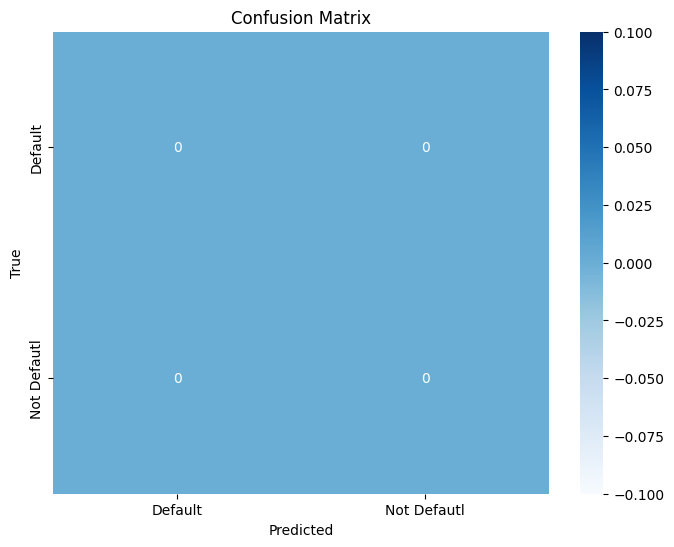


Classification Report:


ValueError: max() arg is an empty sequence

In [ ]:
#Bảo
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

y_true = [res["True Label"] for res in test_results]
y_pred = []
for i in test_results:
    pre = i["Predicted"]
    pattern = re.compile(r'^### Response:\n(Default|Not Defautl)$', re.MULTILINE)
    a = pattern.search(pre)
    if pattern.search(pre):
        y_pred.append(a.group(1))
    else:
        y_pred.append(None)

y_true_filtered = [true for true, pred in zip(y_true, y_pred) if pred is not None]
y_pred_filtered = [pred for pred in y_pred if pred is not None]


cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=['Default', 'Not Defautl'])
cm_df = pd.DataFrame(cm, index=['Default', 'Not Defautl'], columns=['Default', 'Not Defautl'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true_filtered, y_pred_filtered))


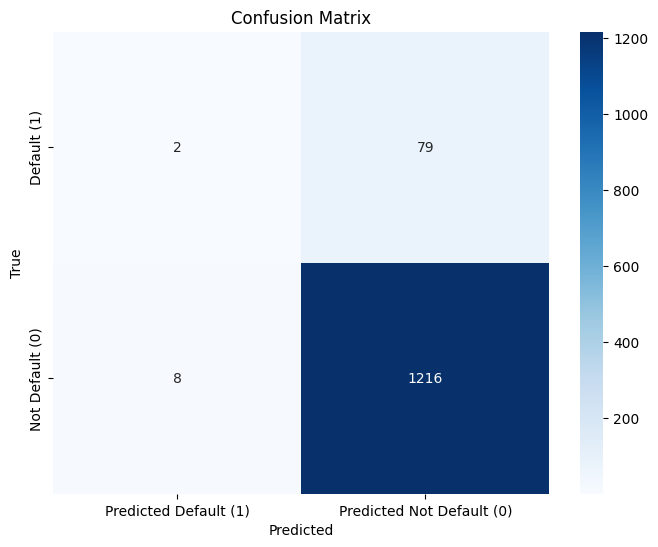


Classification Report:
                 precision    recall  f1-score   support

Not Default (0)       0.94      0.99      0.97      1224
    Default (1)       0.20      0.02      0.04        81

       accuracy                           0.93      1305
      macro avg       0.57      0.51      0.50      1305
   weighted avg       0.89      0.93      0.91      1305



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

# Map text labels to binary labels
label_map_text = {
    "Default": 1,
    "Not Default": 0,
    "High Risk": 1,
    "Low Risk": 0,
    "1": 1,
    "0": 0
}

pattern = re.compile(r'### Response:\s*(Default|Not Default|High Risk|Low Risk|0|1)', re.IGNORECASE)

y_true = []
y_pred = []

for i in test_results:
    true = int(i["True Label"])
    pre = i["Predicted"]

    match = pattern.search(pre)
    if match:
        pred_text = match.group(1).strip().title()
        pred = label_map_text.get(pred_text)
        if pred is not None:
            y_true.append(true)
            y_pred.append(pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # 1 = Default, 0 = Not Default
cm_df = pd.DataFrame(cm, index=["Default (1)", "Not Default (0)"], columns=["Predicted Default (1)", "Predicted Not Default (0)"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Not Default (0)", "Default (1)"]))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import torch

def clean_prediction(text):
    # Chỉ lấy số 0 hoặc 1 đầu tiên xuất hiện trong kết quả sinh ra
    for token in text.split():
        if token.strip() in ["0", "1"]:
            return int(token.strip())
    return 0  # Nếu không có, trả về 0

def validate_model(valid_data, tokenizer, model, prompt):
    true_labels = []
    pred_labels = []
    results = []
    model.eval()  # Đặt chế độ eval để tắt dropout, batchnorm
    for index, row in tqdm(valid_data.iterrows()):
        input_text = prompt.format(
            row["instruction"],
            row["input"],
            ""
        )
        inputs = tokenizer([input_text], return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=8, use_cache=True)
        generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        pred_label = clean_prediction(generated_text)
        true_labels.append(row["output"])
        pred_labels.append(pred_label)
        results.append({
            "Index": index,
            "True Label": row["output"],
            "Predicted": pred_label,
            "Raw": generated_text
        })

    # In báo cáo
    print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
    print("Classification Report:\n", classification_report(true_labels, pred_labels))
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    return results

# Ví dụ sử dụng:
valid_results = validate_model(valid_dataset.to_pandas(), tokenizer, model, prompt)

305it [00:53,  5.75it/s]

Confusion Matrix:
 [[217  67]
 [ 15   6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       284
           1       0.08      0.29      0.13        21

    accuracy                           0.73       305
   macro avg       0.51      0.52      0.48       305
weighted avg       0.88      0.73      0.79       305

Accuracy: 0.7311475409836066


In [ ]:
print(f"Accuracy {acc/len(test_results)}")

Accuracy 0.7896666666666666


In [ ]:
#bỏ đi từ đây
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted')
precision = precision_score(y_true_filtered, y_pred_filtered, average='weighted')
recall = recall_score(y_true_filtered, y_pred_filtered, average='weighted')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


In [ ]:


mal_data = formatting_dataset(dt)
dataset = Dataset.from_pandas(mal_data)
dataset = dataset.map(formatting_prompts_func, batched = True)
# split_dataset = dataset.train_test_split(test_size = 0.2, shuffle=True, seed=42)

# train_dataset = split_dataset["train"]
test_dataset = dataset

In [ ]:
FastLanguageModel.for_inference(model)
def test_model(test_data, tokenizer, model):
    results = []
    # idx = 0
    for index, row in tqdm(test_data.iterrows()):
        # idx += 1
        # if idx > 1000:
        #     break
        # Create input prompt
        input_text = prompt.format(
            row["instruction"],  # Instruction
            row["input"],  # Input (memory dump data)
            ""  # Leave output blank for generation
        )

        # Tokenize the input
        inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

        # Generate output
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=8, use_cache=True)

        # Decode and store results
        generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        results.append({"True Label": row["output"], "Predicted": generated_text})

    return results

# Run the test
test_results = test_model(test_dataset.to_pandas(), tokenizer, model)

# # Print results
# for res in test_results[:10]:  # Show first 10 samples
#     print(res)

In [ ]:
test_results

In [ ]:
import re

# print(len(test_results))
acc = 0
for i in test_results:
  pre = i["Predicted"]
  label = i["True Label"]
  pattern = re.compile(r'^### Response:\n(Malware|Benign)$', re.MULTILINE)
  a = pattern.search(pre)
  if pattern.search(pre):
    res = a.group(1)
    # print(f"True label: {label:>8} | Predict: {a.group(1):>8}")
    if(res == label):
      acc += 1
    # print(label)


In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

y_true = [res["True Label"] for res in test_results]
y_pred = []
for i in test_results:
    pre = i["Predicted"]
    pattern = re.compile(r'^### Response:\n(Malware|Benign)$', re.MULTILINE)
    a = pattern.search(pre)
    if pattern.search(pre):
        y_pred.append(a.group(1))
    else:
        y_pred.append(None)

y_true_filtered = [true for true, pred in zip(y_true, y_pred) if pred is not None]
y_pred_filtered = [pred for pred in y_pred if pred is not None]


cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=['Malware', 'Benign'])
cm_df = pd.DataFrame(cm, index=['Malware', 'Benign'], columns=['Malware', 'Benign'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_true_filtered, y_pred_filtered))


In [ ]:
print(f"Accuracy {acc/len(test_results)}")

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted')
precision = precision_score(y_true_filtered, y_pred_filtered, average='weighted')
recall = recall_score(y_true_filtered, y_pred_filtered, average='weighted')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
